In [61]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
# import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
peak_hours_path = "2022-peak-hours-ca - 2022 Peak Hour Report.csv"
traffic_volumes_path = "2022 AADT DATA - 2022 AADT DATA.csv"

peak_hours_df = pd.read_csv(peak_hours_path)
traffic_volumes_df = pd.read_csv(traffic_volumes_path)

peak_hours_df.rename(columns={"RTE": "ROUTE", "CO": "COUNTY"}, inplace=True)

""" merging the dataframes """

merged_df = pd.merge(
    traffic_volumes_df,
    peak_hours_df,
    on=["ROUTE", "COUNTY", "PM"],
    how="inner"
)

print(f"Merged {len(merged_df)} rows from Caltrans data.")

Merged 1084 rows from Caltrans data.


In [63]:
# print(merged_df.columns)

# merged_df[["AM_DAY","PM_DAY","DISTRICT","ROUTE","COUNTY"]]

important columns are 
- ROUTE
- COUNTY
- DAY : day of the week
- PHV : peak hour volume
- AM_DIR : direction of travel for peak volume in morning
- PM_DIR : direction of travel for peak volume in at night
- AADT : annual average daily traffic in vehicles per day


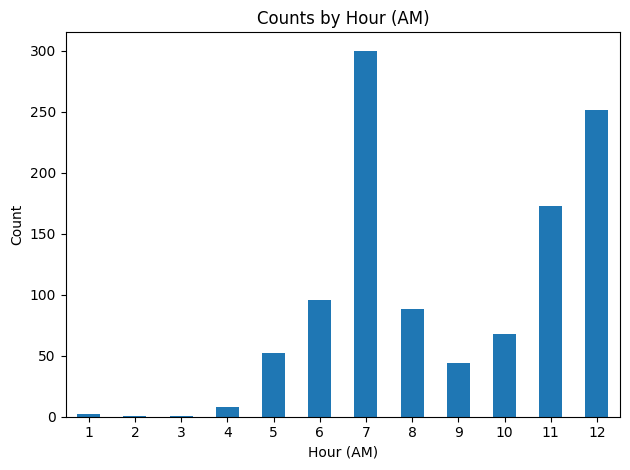

In [64]:
merged_df["AM_HOUR"].value_counts().sort_index().plot(kind='bar')

plt.xlabel("Hour (AM)")
plt.ylabel("Count")
plt.title("Counts by Hour (AM)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


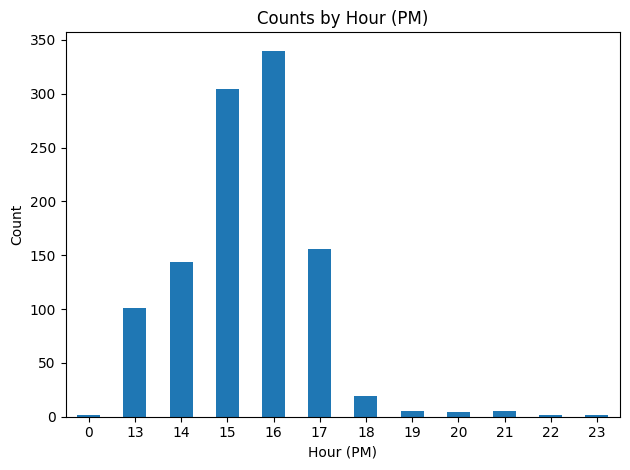

In [65]:
merged_df["PM_HOUR"].value_counts().sort_index().plot(kind='bar')

plt.xlabel("Hour (PM)")
plt.ylabel("Count")
plt.title("Counts by Hour (PM)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [66]:
merged_df.replace({
    'JAN': 0, 'FEB': 1, 'MAR': 2, 'APR': 3,
    'MAY': 4, 'JUN': 5, 'JUL': 6, 'AUG': 7,
    'SEP': 8, 'OCT': 9, 'NOV': 10, 'DEC': 11
}, inplace=True)

merged_df.replace({
    'MON': 0, 'TUE': 1, 'WED': 2, 'THU': 3,
    'FRI': 4, 'SAT': 5, 'SUN': 6
}, inplace=True)

merged_df.replace({'N': 0, 'S': 1, 'E': 2, 'W': 3}, inplace=True)

C:\Users\ryana\AppData\Local\Temp\ipykernel_43496\837827291.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace({
C:\Users\ryana\AppData\Local\Temp\ipykernel_43496\837827291.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace({
C:\Users\ryana\AppData\Local\Temp\ipykernel_43496\837827291.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the futu

In [67]:
normalized_am_distribution = merged_df["AM_HOUR"].value_counts(normalize=True).to_dict()
normalized_pm_distribution = merged_df["PM_HOUR"].value_counts(normalize=True).to_dict()


In [68]:
merged_df

,DISTRICT,ROUTE,ROUTE_SFX,COUNTY,PM_PFX_x,PM,PM_SFX_x,LOCATION DESCRIPTION,BACK_PEAK_HOUR,BACK_PEAK_MADT,...,AM_DAY,AM_MONTH,PM_DIR,PM_WAY_PHV,PM_K_FACTOR_AMT,PM_D_FACTOR_AMT,PM_KD_FACTOR,PM_HOUR,PM_DAY,PM_MONTH
0,5,1,NaN,SB,R,0.000,NaN,"LAS CRUCES, JCT. RTE. 101",NaN,NaN,...,1,4,0,685,11.04,80.49,8.89,16,3,6
1,5,1,NaN,SB,NaN,19.251,NaN,"LOMPOC, SOUTH JCT. RTE. 246",900.0,8400.0,...,3,10,0,749,11.85,84.44,10.00,17,3,10
2,5,1,NaN,SB,NaN,20.565,NaN,"LOMPOC, NORTH JCT. RTE. 246",1700.0,13500.0,...,5,2,1,541,8.86,52.37,4.64,15,4,5
3,5,1,NaN,SB,NaN,22.519,NaN,"LOMPOC, SANTA YNEZ RIVER BRIDGE",2700.0,28000.0,...,1,1,1,1400,10.42,51.55,5.37,17,3,1
4,5,1,NaN,SB,R,23.296,NaN,LOMPOC/CASMALIA ROAD,2700.0,28500.0,...,0,8,0,995,9.98,52.81,5.27,17,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,11,805,NaN,SD,NaN,24.440,NaN,GOVERNOR DRIVE,14500.0,195000.0,...,1,5,1,8761,7.22,60.19,4.34,14,1,8
1080,11,805,NaN,SD,NaN,28.502,NaN,JCT. RTE. 5,9600.0,141000.0,...,1,4,1,6722,7.50,55.18,4.14,16,3,3
1081,4,880,NaN,ALA,NaN,14.537,NaN,"HAYWARD, INDUSTRIAL PARKWAY",13500.0,211000.0,...,5,3,1,6630,6.72,52.25,3.51,13,5,4
1082,11,905,NaN,SD,NaN,3.207,R,JCT RTE 5,870.0,10000.0,...,2,1,2,2562,8.72,53.46,4.66,15,4,1


In [69]:
merged_df[['BACK_AADT','AHEAD_AADT']]

,BACK_AADT,AHEAD_AADT
0,NaN,7700.0
1,7900.0,12000.0
2,12000.0,11600.0
3,26000.0,26000.0
4,26000.0,18800.0
...,...,...
1079,185000.0,181000.0
1080,129000.0,NaN
1081,201000.0,217000.0
1082,9700.0,24500.0


## Understanding the AADT Columns

AHEAD means North of a location.
BACK means South of a location. 

These are usually the same because the cars to a location are the same cars coming back from a location. 

- Back Peak Hour - is the estimated volume of traffic going south of a location during RUSH HOUR
- Back Peak MADT - is the estimated MONTHLY volume of traffic going south of a location during RUSH HOUR
- Back Peak AADT - is the estimated ANNUAL volume of traffic going south of a location during RUSH HOUR

## Boosting Algorithm

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- Simulated multiplier function (adjust if needed)
def calculate_multiplier(back_peak_hour, ahead_peak_hour, back_aadt, ahead_aadt, am_hour=None, pm_hour=None, am_distribution=None, pm_distribution=None):
    base_multiplier = 1.0

    if am_hour is not None and am_distribution is not None:
        hour_weight = am_distribution.get(am_hour, 0)  # default to 0 if hour not found
        base_multiplier += hour_weight * 1.564  # we can change this

    if pm_hour is not None and pm_distribution is not None:
        hour_weight = pm_distribution.get(pm_hour, 0)
        base_multiplier += hour_weight * 1.568  # we can change this

    # AADT scaling
    avg_aadt = (back_aadt + ahead_aadt) / 2
    base_multiplier += avg_aadt / 400000

    # noise
    return max(base_multiplier + np.random.normal(0, 0.05), 1.0)


def encode_month(month):
    return int(month) if pd.notna(month) else 0

def encode_day(day):
    return int(day) if pd.notna(day) else 0

X_morning, y_morning = [], []
X_night, y_night = [], []

for i, row in merged_df.iterrows():
    try:
        # Safe parsing
        am_month = encode_month(row.get("AM_MONTH"))
        am_day = encode_day(row.get("AM_DAY"))
        am_hour = row.get("AM_HOUR")
        pm_month = encode_month(row.get("PM_MONTH"))
        pm_day = encode_day(row.get("PM_DAY"))
        pm_hour = row.get("PM_HOUR")
        back_aadt = row.get("BACK_AADT")
        ahead_aadt = row.get("AHEAD_AADT")
        back_peak = row.get("BACK_PEAK_HOUR")
        ahead_peak = row.get("AHEAD_PEAK_HOUR")

        # Check required fields
        if any(pd.isna(v) for v in [am_hour, pm_hour, back_aadt, ahead_aadt, back_peak, ahead_peak]):
            continue

        # Convert to int/float safely
        am_hour = int(am_hour)
        pm_hour = int(pm_hour)
        back_aadt = float(back_aadt)
        ahead_aadt = float(ahead_aadt)
        back_peak = int(back_peak)
        ahead_peak = int(ahead_peak)

        # Append to morning
        X_morning.append([am_month, am_day, am_hour, back_aadt, ahead_aadt])
        y_morning.append(calculate_multiplier(back_peak, ahead_peak, back_aadt, ahead_aadt, am_hour=am_hour))

        # Append to night
        X_night.append([pm_month, pm_day, pm_hour, back_aadt, ahead_aadt])
        y_night.append(calculate_multiplier(back_peak, ahead_peak, back_aadt, ahead_aadt, pm_hour=pm_hour))

    except Exception as e:
        print(f"Row {i} skipped due to error: {e}")
        continue

print(f"Prepared {len(X_morning)} morning and {len(X_night)} night examples.")


def train_svm_model(X, y):
    X = np.array(X)
    y = np.array(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    model = SVR(kernel='linear', C=1.0, epsilon=0.1)
    model.fit(X_train, y_train)

    return model, scaler, X_test, y_test


def evaluate_svm_model(model, X_test, y_test, feature_names=None):
    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"SVM R² score: {score:.3f}")
    print(f"SVM MAE: {mae:.3f}")
    print(f"SVM RMSE: {rmse:.3f}")
    print()

    # Plot 1: Actual vs Predicted
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Multiplier")
    plt.ylabel("Predicted Multiplier")
    plt.title("Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Prediction Error (Residual)")
    plt.title("Distribution of Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Feature Importance
    if feature_names is not None:
        results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importance = results.importances_mean
        sorted_idx = importance.argsort()[::-1]

        plt.figure(figsize=(8, 5))
        sns.barplot(x=importance[sorted_idx], y=np.array(feature_names)[sorted_idx])
        plt.title("Feature Importance (Permutation)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

Prepared 907 morning and 907 night examples.


In [71]:
samples = [
    calculate_multiplier(
        back_peak_hour=back_peak,
        ahead_peak_hour=ahead_peak,
        back_aadt=row[3],
        ahead_aadt=row[4],
        pm_hour=row[2],
        pm_distribution=normalized_pm_distribution
    )
    for row in X_night
]

best_value = np.mean(samples)  # or np.median(samples)
print(best_value)

1.471381184112929


Morning SVM:
SVM R² score: 0.912
SVM MAE: 0.038
SVM RMSE: 0.046



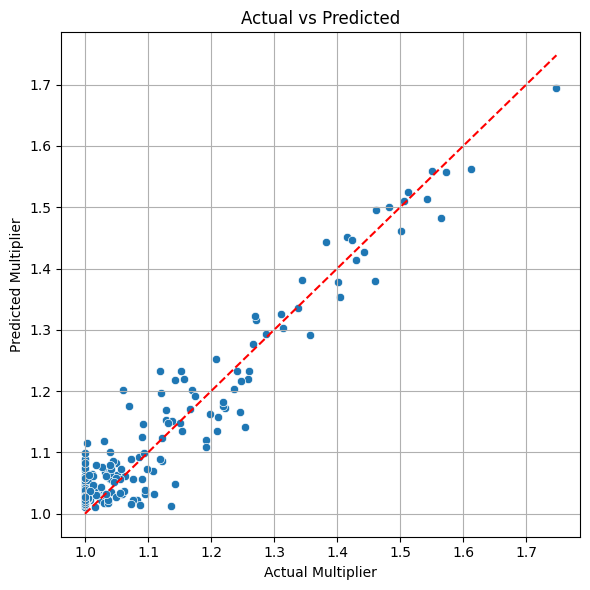

Night SVM:
SVM R² score: 0.927
SVM MAE: 0.034
SVM RMSE: 0.041



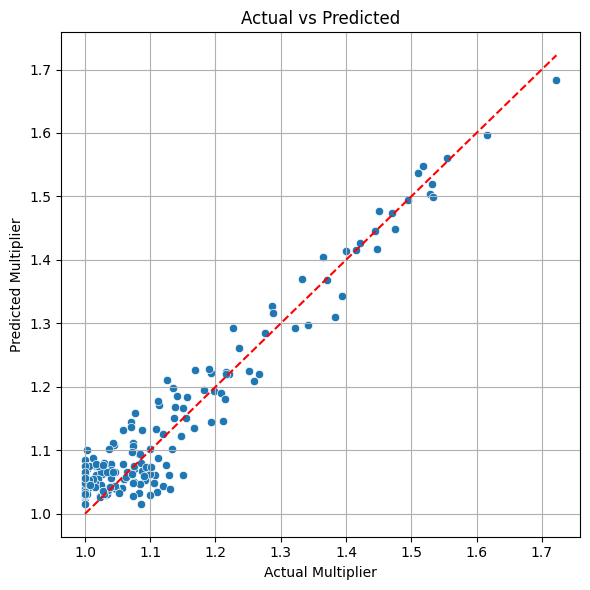

In [72]:
feature_names = ["AM_HOUR", "PM_HOUR", "AM_DIRECTION", "PM_DIRECTION", 
                 "BACK_AADT"]

print("Morning SVM:")
morning_svm, morning_scaler, X_morning_test, y_morning_test = train_svm_model(X_morning, y_morning)
evaluate_svm_model(morning_svm, X_morning_test, y_morning_test, feature_names)


print("Night SVM:")
night_svm, night_scaler, X_night_test, y_night_test = train_svm_model(X_night, y_night)
evaluate_svm_model(night_svm, X_night_test, y_night_test, feature_names)

In [73]:
for i in range(len(feature_names)):
    print(f'{feature_names[i]} : {morning_svm.coef_[0][i]}')

print(f'Bias: {morning_svm.intercept_}')

AM_HOUR : 0.007821940898408597
PM_HOUR : -0.0072474312430882495
AM_DIRECTION : 0.0016093352887294188
PM_DIRECTION : 0.07248789647773224
BACK_AADT : 0.06664647916663669
Bias: [1.1266918]


In [74]:
for i in range(len(feature_names)):
    print(f'{feature_names[i]} : {night_svm.coef_[0][i]}')

print(f'Bias: {night_svm.intercept_}')

AM_HOUR : -0.002560177258270513
PM_HOUR : -0.006298802475391607
AM_DIRECTION : -0.0040473050231977226
PM_DIRECTION : 0.08492468197180442
BACK_AADT : 0.051499841612093034
Bias: [1.13430148]


In [75]:
import pandas as pd
df = pd.DataFrame(X_morning_test, columns=feature_names)
df['target'] = y_morning_test
df.corr()['target'].sort_values(ascending=False)

target          1.000000
BACK_AADT       0.952021
PM_DIRECTION    0.946467
AM_HOUR        -0.060673
PM_HOUR        -0.189697
AM_DIRECTION   -0.203641
Name: target, dtype: float64

## Understanding our Data

In [76]:
def plot_traffic_over_time(X_morning, y_morning, model, scaler):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create DataFrame from raw features and target
    df = pd.DataFrame(X_morning, columns=["AM_MONTH", "AM_DAY", "AM_HOUR", "BACK_AADT", "AHEAD_AADT"])
    df["y_true"] = y_morning

    # Create datetime index (using 2024 as placeholder year)
    df["datetime"] = pd.to_datetime({
        "year": 2022,
        "month": df["AM_MONTH"] + 1,
        "day": df["AM_DAY"],
        "hour": df["AM_HOUR"]
    }, errors='coerce')

    df = df.dropna(subset=["datetime"])  # drop invalid dates
    df = df.sort_values("datetime")

    # Predict using scaled inputs
    X_scaled = scaler.transform(df[["AM_MONTH", "AM_DAY", "AM_HOUR", "BACK_AADT", "AHEAD_AADT"]])
    df["predicted_multiplier"] = model.predict(X_scaled)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="datetime", y="predicted_multiplier", data=df, label="Predicted", marker="o")
    sns.lineplot(x="datetime", y="y_true", data=df, label="Actual", marker="x")
    plt.title("Traffic Multiplier Over Time (Morning)")
    plt.xlabel("Time")
    plt.ylabel("Multiplier")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


c:\Users\ryana\Desktop\CSUF\SPRING 2025\483-ml\theta-svm-ryan\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


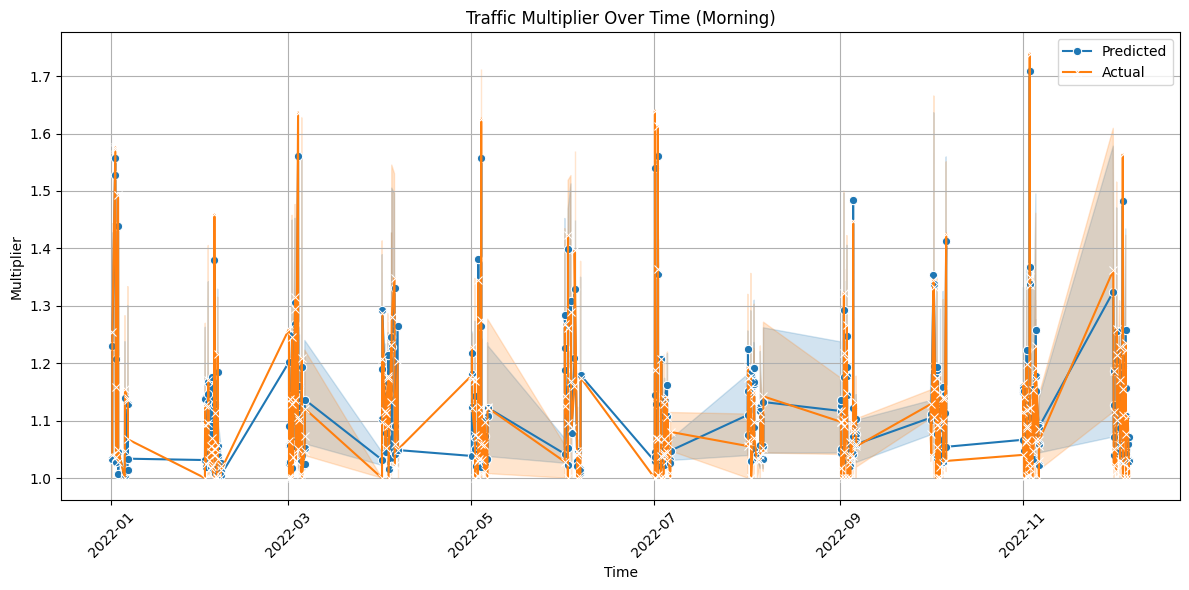

c:\Users\ryana\Desktop\CSUF\SPRING 2025\483-ml\theta-svm-ryan\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


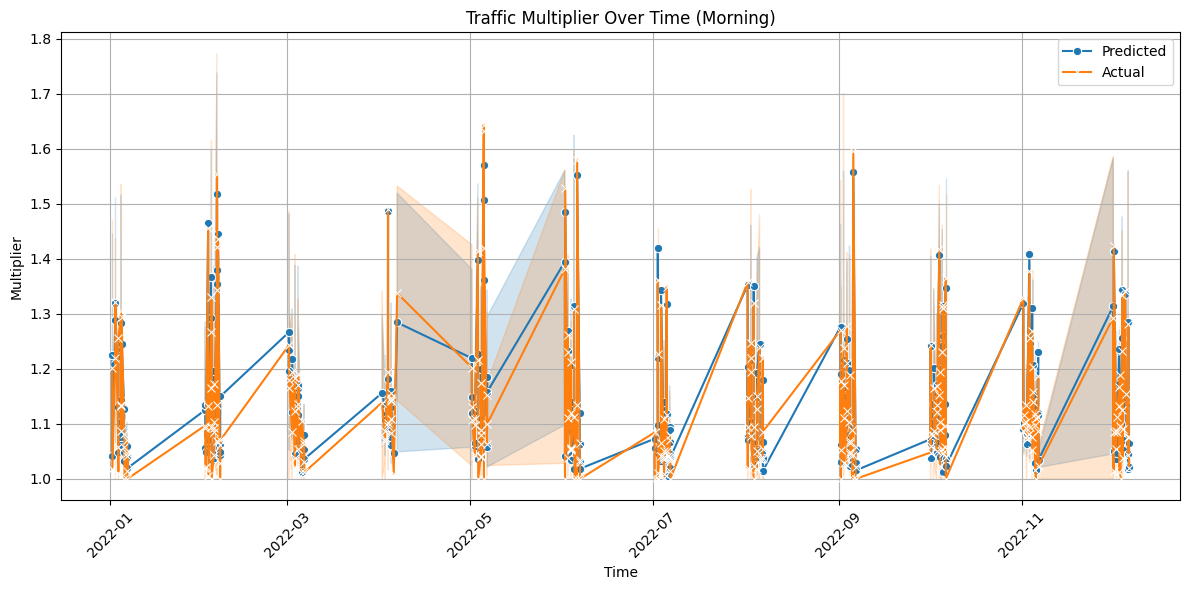

In [77]:
# model_morning, scaler_morning = train_svm(X_morning, y_morning)
plot_traffic_over_time(X_morning, y_morning, morning_svm, morning_scaler)
plot_traffic_over_time(X_night, y_night, night_svm, night_scaler)

In [78]:
def interpret_prediction(model_input, prediction):
    direction_map = {0: 'North', 1: 'South', 2: 'East', 3: 'West'}
    
    am_dir_code, pm_dir_code, back_peak, ahead_peak, back_aadt, ahead_aadt = model_input[0]
    
    am_direction = direction_map.get(am_dir_code, 'Unknown')
    pm_direction = direction_map.get(pm_dir_code, 'Unknown')
    
    summary = (
        f"At heading {pm_direction}, "
        f"traffic is expected to be {prediction[0]:.2f}× heavier than normal.\n"
        f"This is due to:\n"
        f"- Morning conditions: heading {am_direction}\n"
        f"- Nearby peak hours: BACK at {back_peak}:00, AHEAD at {ahead_peak}:00\n"
        f"- Traffic volumes: BACK AADT = {back_aadt}, AHEAD AADT = {ahead_aadt}"
    )
    return summary